# Downloading dataset

In [ ]:
# Install required libraries (minimal, as OpenCV is pre-installed in Colab)
!pip install kagglehub ffmpeg-python

import kagglehub
import os
import shutil
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import glob
import uuid
from google.colab import files

# Step 1: Set up Kaggle API in Colab
print("Upload your kaggle.json file")
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 2: Download dataset using kagglehub
print("Downloading IMVIA Fall Detection dataset...")
path = kagglehub.dataset_download("tuyenldvn/falldataset-imvia")
print("Default path to dataset files:", path)

# Step 3: Move dataset to /content/falldataset-imvia
target_path = "/content/falldataset-imvia"
if os.path.exists(target_path):
    shutil.rmtree(target_path)
shutil.copytree(path, target_path)
print(f"Dataset moved to: {target_path}")
print("Dataset contents:", os.listdir(target_path))


Upload your kaggle.json file


Saving kaggle.json to kaggle.json


100%|██████████| 9.37G/9.37G [01:48<00:00, 93.1MB/s]

Extracting files...


Default path to dataset files: /root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2
Dataset moved to: /content/falldataset-imvia
Dataset contents: ['README.txt', 'Coffee_room_02', 'Home_01', 'Office', 'Lecture_room', 'Home_02', 'Coffee_room_01']


In [46]:
# !pip install mediapipe opencv-python --quiet

import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import os


# Extracting Features

In [ ]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

def extract_keypoints_from_video(video_path):
    cap = cv2.VideoCapture(video_path)
    keypoints_sequence = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = pose.process(frame_rgb)

        if result.pose_landmarks:
            frame_keypoints = []
            for lm in result.pose_landmarks.landmark:
                frame_keypoints.append([lm.x, lm.y, lm.z, lm.visibility])
            keypoints_sequence.append(frame_keypoints)

    cap.release()
    return np.array(keypoints_sequence)  # shape: (frames, 33, 4)


In [ ]:
def compute_center_of_gravity(keypoints_frame):
    return np.mean(keypoints_frame[:, :3], axis=0)  # mean of x, y, z

def compute_velocity(keypoints_seq):
    return np.linalg.norm(np.diff(keypoints_seq[:, :, :3], axis=0), axis=2)  # shape: (T-1, 33)

def compute_joint_angles(keypoints_frame):
    def angle(a, b, c):
        a, b, c = np.array(a), np.array(b), np.array(c)
        ba, bc = a - b, c - b
        cosine = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
        return np.degrees(np.arccos(np.clip(cosine, -1.0, 1.0)))

    # Define landmark indices for left and right elbow angles
    LEFT_SHOULDER, LEFT_ELBOW, LEFT_WRIST = 11, 13, 15
    RIGHT_SHOULDER, RIGHT_ELBOW, RIGHT_WRIST = 12, 14, 16

    # Calculate left elbow angle
    angle_left_elbow = angle(keypoints_frame[LEFT_SHOULDER][:3],
                             keypoints_frame[LEFT_ELBOW][:3],
                             keypoints_frame[LEFT_WRIST][:3])

    # Calculate right elbow angle
    angle_right_elbow = angle(keypoints_frame[RIGHT_SHOULDER][:3],
                              keypoints_frame[RIGHT_ELBOW][:3],
                              keypoints_frame[RIGHT_WRIST][:3])

    return [angle_left_elbow, angle_right_elbow]  # Return both angles

    # Example: left_elbow angle = shoulder, elbow, wrist
    LEFT_SHOULDER, LEFT_ELBOW, LEFT_WRIST = 11, 13, 15
    angle_left_elbow = angle(keypoints_frame[LEFT_SHOULDER][:3], keypoints_frame[LEFT_ELBOW][:3], keypoints_frame[LEFT_WRIST][:3])

    return [angle_left_elbow]  # Add more joints as needed


In [ ]:
def process_all_videos(root_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith(".avi"):
                full_path = os.path.join(dirpath, filename)
                print(f"Processing {full_path}...")

                kp_seq = extract_keypoints_from_video(full_path)
                if len(kp_seq) == 0:
                    print("No keypoints found, skipping.")
                    continue

                cog_list = [compute_center_of_gravity(f) for f in kp_seq]
                angle_list = [compute_joint_angles(f) for f in kp_seq]
                vel_seq = compute_velocity(kp_seq)

                df = pd.DataFrame()
                df['cog_x'] = [x[0] for x in cog_list]
                df['cog_y'] = [x[1] for x in cog_list]
                df['cog_z'] = [x[2] for x in cog_list]
                df['angle_left_elbow'] = [a[0] for a in angle_list]
                df['angle_right_elbow'] = [a[1] for a in angle_list]

                for j in range(33):
                    vel_column = np.pad(vel_seq[:, j], (1, 0), mode='constant')
                    df[f'vel_joint_{j}'] = vel_column
g
                df['conf_mean'] = [np.mean(f[:, 3]) for f in kp_seq]

                label = 1 if "fall" in filename.lower() else 0
                df['label'] = label

                # Save to output directory with folder name prefix
                video_name = os.path.splitext(filename)[0]
                relative_folder = os.path.relpath(dirpath, root_dir).replace('/', '_')
                output_file = os.path.join(output_dir, f"{video_name}.csv")
                df.to_csv(output_file, index=False)


In [ ]:
dataset_dir = "/content/falldataset-imvia"
process_all_videos(dataset_dir, "/content/features")

Processing /content/falldataset-imvia/Coffee_room_02/Coffee_room_02/Videos/video (62).avi...
Processing /content/falldataset-imvia/Coffee_room_02/Coffee_room_02/Videos/video (67).avi...
Processing /content/falldataset-imvia/Coffee_room_02/Coffee_room_02/Videos/video (51).avi...
Processing /content/falldataset-imvia/Coffee_room_02/Coffee_room_02/Videos/video (50).avi...
Processing /content/falldataset-imvia/Coffee_room_02/Coffee_room_02/Videos/video (64).avi...
Processing /content/falldataset-imvia/Coffee_room_02/Coffee_room_02/Videos/video (52).avi...
Processing /content/falldataset-imvia/Coffee_room_02/Coffee_room_02/Videos/video (65).avi...
Processing /content/falldataset-imvia/Coffee_room_02/Coffee_room_02/Videos/video (68).avi...
Processing /content/falldataset-imvia/Coffee_room_02/Coffee_room_02/Videos/video (57).avi...
Processing /content/falldataset-imvia/Coffee_room_02/Coffee_room_02/Videos/video (70).avi...
Processing /content/falldataset-imvia/Coffee_room_02/Coffee_room_02/Vi

In [ ]:
import os
import pandas as pd
import shutil

def is_fall_annotation(annotation_file):
    try:
        with open(annotation_file, 'r') as f:
            lines = [line.strip() for line in f.readlines() if line.strip()]
            if len(lines) < 2:
                return False
            if lines[0] == '0' and lines[1] == '0':
                return False
            return True
    except:
        return False

def collect_all_annotations(annotation_root_dir):
    """
    Collect all annotation file paths and map them to video filenames.
    Example: 'video (54).txt' → full annotation file path
    """
    annotation_map = {}
    for root, _, files in os.walk(annotation_root_dir):
        for file in files:
            if file.startswith('video') and file.endswith('.txt'):
                annotation_map[file.replace('.txt', '')] = os.path.join(root, file)
    return annotation_map

def split_dataset(feature_root_dir, annotation_root_dir, output_dir):
    os.makedirs(os.path.join(output_dir, 'x_train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'y_train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'x_test'), exist_ok=True)

    annotation_map = collect_all_annotations(annotation_root_dir)
    print(annotation_map)
    for root, _, files in os.walk(feature_root_dir):
        print(files)
        for file in files:
            if file.endswith('.csv'):
                video_id = file.replace('.csv', '')  # like 'video (54)'
                full_csv_path = os.path.join(root, file)

                if video_id in annotation_map:
                    label = 1 if is_fall_annotation(annotation_map[video_id]) else 0
                    shutil.copy(full_csv_path, os.path.join(output_dir, 'x_train', file))
                    with open(os.path.join(output_dir, 'y_train', video_id + '.txt'), 'w') as label_file:
                        label_file.write(str(label))
                else:
                    shutil.copy(full_csv_path, os.path.join(output_dir, 'x_test', file))

    print("✅ Dataset split completed!")

# Example usage:
split_dataset(
    feature_root_dir="/content/features",
    annotation_root_dir="/content/falldataset-imvia",  # this can contain nested annotation dirs
    output_dir="/content/fall_split_dataset"
)


{'video (65)': '/content/falldataset-imvia/Coffee_room_02/Coffee_room_02/Annotations_files/video (65).txt', 'video (57)': '/content/falldataset-imvia/Home_02/Home_02/Annotation_files/video (57).txt', 'video (55)': '/content/falldataset-imvia/Home_02/Home_02/Annotation_files/video (55).txt', 'video (68)': '/content/falldataset-imvia/Coffee_room_02/Coffee_room_02/Annotations_files/video (68).txt', 'video (54)': '/content/falldataset-imvia/Home_02/Home_02/Annotation_files/video (54).txt', 'video (56)': '/content/falldataset-imvia/Home_02/Home_02/Annotation_files/video (56).txt', 'video (51)': '/content/falldataset-imvia/Home_02/Home_02/Annotation_files/video (51).txt', 'video (49)': '/content/falldataset-imvia/Home_02/Home_02/Annotation_files/video (49).txt', 'video (61)': '/content/falldataset-imvia/Coffee_room_02/Coffee_room_02/Annotations_files/video (61).txt', 'video (62)': '/content/falldataset-imvia/Coffee_room_02/Coffee_room_02/Annotations_files/video (62).txt', 'video (67)': '/con

# Loading Extracted features

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


DATA_DIR = "/content/fall_split_dataset"
SEQ_LEN = 500
def load_train_data(x_dir, y_dir):
    sequences = []
    labels = []

    for file in sorted(os.listdir(x_dir)):
        if not file.endswith('.csv'):
            continue

        csv_path = os.path.join(x_dir, file)
        txt_path = os.path.join(y_dir, file.replace(".csv", ".txt"))

        df = pd.read_csv(csv_path)
        features = df.drop(columns=["frame"], errors='ignore').values

        if os.path.exists(txt_path):
            with open(txt_path, 'r') as f:
                try:
                    label = int(f.read().strip())
                except:
                    label = 0
        else:
            label = 0

        if len(features) < SEQ_LEN:
            pad_len = SEQ_LEN - len(features)
            padded_seq = np.pad(features, ((0, pad_len), (0, 0)), mode='constant')
            sequences.append(padded_seq)
            labels.append(label)
        else:
            for i in range(0, len(features) - SEQ_LEN + 1, SEQ_LEN):
                seq = features[i:i + SEQ_LEN]
                sequences.append(seq)
                labels.append(label)

    return np.array(sequences), np.array(labels)



x_train_dir = os.path.join(DATA_DIR, "x_train")
y_train_dir = os.path.join(DATA_DIR, "y_train")
x, y = load_train_data(x_train_dir, y_train_dir)
print(f"Total sequences: {x.shape}, Labels: {np.unique(y, return_counts=True)}")



Total sequences: (74, 500, 40), Labels: (array([0, 1]), array([23, 51]))


# Visualizing dataset distribution

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1]


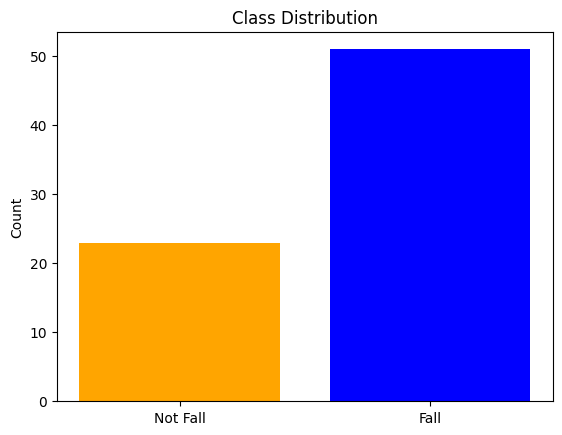

In [ ]:
import matplotlib.pyplot as plt
labels = ['Fall', 'Not Fall']
print(y)

unique, counts = np.unique(y, return_counts=True)

# Plot
plt.bar(['Not Fall', 'Fall'], counts, color=['orange', 'blue'])
plt.title('Class Distribution')
plt.ylabel('Count')
plt.show()

# Training Model

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
import numpy as np

# Split the data into train and test sets first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE on the training set to balance the class distribution
X_train_reshaped = X_train.reshape((X_train.shape[0], -1))
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_reshaped, y_train)

# Reshape back to the original sequence format
X_train_balanced = X_train_balanced.reshape((-1, SEQ_LEN, num_features))

# Compute class weights for the balanced training set
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

# Build the model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(SEQ_LEN, num_features)),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    class_weight=class_weight_dict
)

# Evaluate the model on the test set
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")


Class Weights: {0: 1.0, 1: 1.0}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5451 - loss: 0.6890 - val_accuracy: 0.6027 - val_loss: 0.6683
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 783ms/step - accuracy: 0.6458 - loss: 0.6323 - val_accuracy: 0.6438 - val_loss: 0.6524
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 687ms/step - accuracy: 0.6827 - loss: 0.5697 - val_accuracy: 0.7808 - val_loss: 0.5655
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 664ms/step - accuracy: 0.7640 - loss: 0.5246 - val_accuracy: 0.7808 - val_loss: 0.5129
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 593ms/step - accuracy: 0.7654 - loss: 0.4901 - val_accuracy: 0.8082 - val_loss: 0.4864
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 652ms/step - accuracy: 0.7904 - loss: 0.4558 - val_accuracy: 0.8082 - val_loss: 0.5095
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 932ms/step - accuracy: 0.8197 - loss: 0.4050 - val_accuracy: 0.8493 - val_loss: 0.4379
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 629ms/step - accuracy: 0.8570 - loss: 0.3680 - val_accuracy

# Generating classification reports

In [45]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = y_test.flatten()

# Metrics
print("Classification Report:\n", classification_report(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 805ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.57      0.50        14
           1       0.89      0.83      0.86        59

    accuracy                           0.78        73
   macro avg       0.67      0.70      0.68        73
weighted avg       0.81      0.78      0.79        73

Precision: 0.8909090909090909
Recall: 0.8305084745762712
F1 Score: 0.8596491228070176
Confusion Matrix:
 [[ 8  6]
 [10 49]]


# Creating Animation

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import mediapipe as mp

# Initialize MediaPipe
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

# Create folder to save frames
frame_folder = "/content/drive/MyDrive/Deep Learning Semester 6th/assignment 3/pose_frames"
os.makedirs(frame_folder, exist_ok=True)


# Function to generate and save animation as video
def save_pose_animation(keypoints, out_video_path, frame_folder):
    fig, ax = plt.subplots(figsize=(6, 8))
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)
    scat = ax.scatter([], [], c='red')

    def update(i):
        ax.clear()
        ax.set_xlim(0, 1)
        ax.set_ylim(1, 0)
        kps = np.array(keypoints[i])
        ax.scatter(kps[:, 0], kps[:, 1], c='red')
        ax.set_title(f"Frame {i+1}")
        # Save each frame as an image
        frame_path = os.path.join(frame_folder, f"frame_{i:03d}.png")
        fig.savefig(frame_path)
        return ax,

    ani = FuncAnimation(fig, update, frames=len(keypoints), interval=100)
    ani.save(out_video_path, fps=10, dpi=200)
    plt.close(fig)

# ===== Run everything =====
sequence_dir = "/content/ur_fall_dataset/videos/fall-11-cam0-rgb"
fall_kps = extract_keypoints_from_sequence(sequence_dir)

out_video_path = "/content/drive/MyDrive/Deep Learning Semester 6th/assignment 3/fall_demo_output.mp4"
save_pose_animation(fall_kps, out_video_path, frame_folder)

print(f"Saved animation to: {out_video_path}")
print(f"Saved individual frames to: {frame_folder}")


Saved animation to: /content/drive/MyDrive/Deep Learning Semester 6th/assignment 3/fall_demo_output.mp4
Saved individual frames to: /content/drive/MyDrive/Deep Learning Semester 6th/assignment 3/pose_frames


In [ ]:

sequence_dir = "/content/ur_fall_dataset/videos/adl-11-cam0-rgb"
no_fall_kps = extract_keypoints_from_sequence(sequence_dir)

out_video_path = "/content/drive/MyDrive/Deep Learning Semester 6th/assignment 3/not_fall_demo_output.mp4"
save_pose_animation(no_fall_kps, out_video_path, frame_folder)

print(f"Saved animation to: {out_video_path}")
print(f"Saved individual frames to: {frame_folder}")

Saved animation to: /content/drive/MyDrive/Deep Learning Semester 6th/assignment 3/not_fall_demo_output.mp4
Saved individual frames to: /content/drive/MyDrive/Deep Learning Semester 6th/assignment 3/pose_frames


In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width=600):
  mp4 = open(video_path,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width="{0}" controls>
        <source src="{1}" type="video/mp4">
  </video>
  """.format(video_width, data_url))

# Assuming 'fall_demo_output.mp4' is in the specified directory
show_video('/content/drive/MyDrive/Deep Learning Semester 6th/assignment 3/fall_demo_output.mp4')



In [ ]:
# NO fall
show_video('/content/drive/MyDrive/Deep Learning Semester 6th/assignment 3/not_fall_demo_output.mp4')